In [17]:
# install and import libraries
%%capture
!pip install ir_datasets
!pip install demoji

import re
import html
import string
import datetime as dt

import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from collections import Counter

pd.set_option('max_colwidth', 800)

In [2]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [3]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [4]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

,query_id,title,description,narrative
33,34,coronavirus recovery,What are the longer-term complications of those who recover from COVID-19?,Seeking information on the health outcomes for those that recover from the virus. Excludes studies only focusing on adverse effects related to a particular COVID-19 drug.
35,36,SARS-CoV-2 spike structure,What is the protein structure of the SARS-CoV-2 spike?,"Looking for studies of the structure of the spike protein on the virus using any methods, such as cryo-EM or crystallography"
5,6,coronavirus test rapid testing,what types of rapid testing for Covid-19 have been developed?,Looking for studies identifying ways to diagnose Covid-19 more rapidly.
20,21,coronavirus mortality,what are the mortality rates overall and in specific populations,"Seeking information on COVID-19 fatality rates in different countries and in different population groups based on gender, blood types, or other factors"
6,7,serological tests for coronavirus,are there serological tests that detect antibodies to coronavirus?,Looking for assays that measure immune response to COVID-19 that will help determine past infection and subsequent possible immunity.


,doc_id,title,doi,date,abstract
86959,v4cstpgm,Location of antigenic sites defined by neutralizing monoclonal antibodies on the S1 avian infectious bronchitis virus glycopolypeptide.,,1992-01-01,"Neutralizing monoclonal antibodies directed against five antigenic sites on the spike (S) S1 glycopolypeptide of avian infectious bronchitis virus (IBV) were used to select neutralization-resistant variants of the virus. By comparing the nucleotide sequence of such variants with the sequence of the IBV parent strain, we located five antigenic sites on the amino acid sequence of the S1 glycopolypeptide. The variants had mutations within three regions corresponding to amino acid residues 24 to 61, 132 to 149 and 291 to 398 of the S1 glycopolypeptide. The location of three overlapping antigenic sites on the IBV spike protein was similar to the location of antigenic sites on the spike protein of other coronaviruses."
185258,6706zxf7,Genome-wide analysis of codon usage bias in Bovine Coronavirus,10.1186/s12985-017-0780-y,2017-06-17,"BACKGROUND: Bovine coronavirus (BCoV) belong to the genus Betacoronavirus of the family Coronaviridae. BCoV are widespread around the world and cause enteric or respiratory infections among cattle, leading to important economic losses to the beef and dairy industry worldwide. To study the relation of codon usage among viruses and their hosts is essential to understand host-pathogen interaction, evasion from host’s immune system and evolution. METHODS: We performed a comprehensive analysis of codon usage and composition of BCoV. RESULTS: The global codon usage among BCoV strains is similar. Significant differences of codon preferences in BCoV genes in relation to codon usage of Bos taurus host genes were found. Most of the highly frequent codons are U-ending. G + C compositional constra..."
99745,a1qunm95,Application of remote diagnosis and treatment during the COVID-19 outbreak and their preliminary outcomesï¼retrospective cohort study,,2020-01-01,"BACKGROUND: The novel coronavirus (severe acute respiratory syndrome coronavirus 2[SARS-CoV-2]) outbreak is now a pandemic, thousands of people now self-quarantined because of possible infection with the coronavirus, this situation makes telemedicine necessary as it can overcome geographical barriers, enlarge the size of the population served, and provide clinical support for patients online, however the outcomes of telemedicine have not yet evaluated. OBJECTIVE: To describe the epidemiological features and clinical symptoms of patients receiving remote diagnosis and treatment at the online outpatient clinic of our hospital during the coronavirus disease 2019 (COVID-19) outbreak, and to analyze the outcomes and advantages of telemedicine during the COVID-19 pandemic. METHODS: All patie..."
42787,9ckwl9ev,Family Member Visits to Critically Ill Patients During COVID-19: A New Pathway (Telemed J E Health 2020. [Epub ahead of print]; DOI: 10.1089/tmj.2020.29040.rb).,10.1089/tmj.2020.0097,2020-04-21,
16150,313sfk69,"Donor-Derived Infections: Incidence, Prevention, and Management",10.1007/978-3-319-28797-3_8,2016-02-15,"Organ donors reflect the diverse US population, and there are an increasing number of donors born in, who have resided in, or who have traveled to underdeveloped areas of the world or areas with geographically restricted infections. As such, these donors are exposed to pathogens that can potentially be transmitted to recipients of the donor’s organs. Additionally, there are newer techniques to identify many pathogens that may be transmitted from the donor to the transplant recipients. Finally, high-profile reports of several donor-derived infections have heightened awareness of donor-derived infections and have likely contributed to increased recognition. In this chapter, the incidence, methods of identification and prevention, and management of unexpected donor-derived infections will..."


,query_id,doc_id,relevance,iteration
69238,50,wzdgizoo,2,5
28634,18,w2uqaz8p,0,0.5
49500,33,vmtpolv9,2,3
11959,8,euqlwqtd,0,2
58872,40,9siu7wgs,2,3.5


* numbers
* punctuation
* symbols
* whitespaces
* stop words
* HTML tags
* repeated characters
* URLs
* emojis

---

- stemming / lemmatization ?

## Preprocessing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  


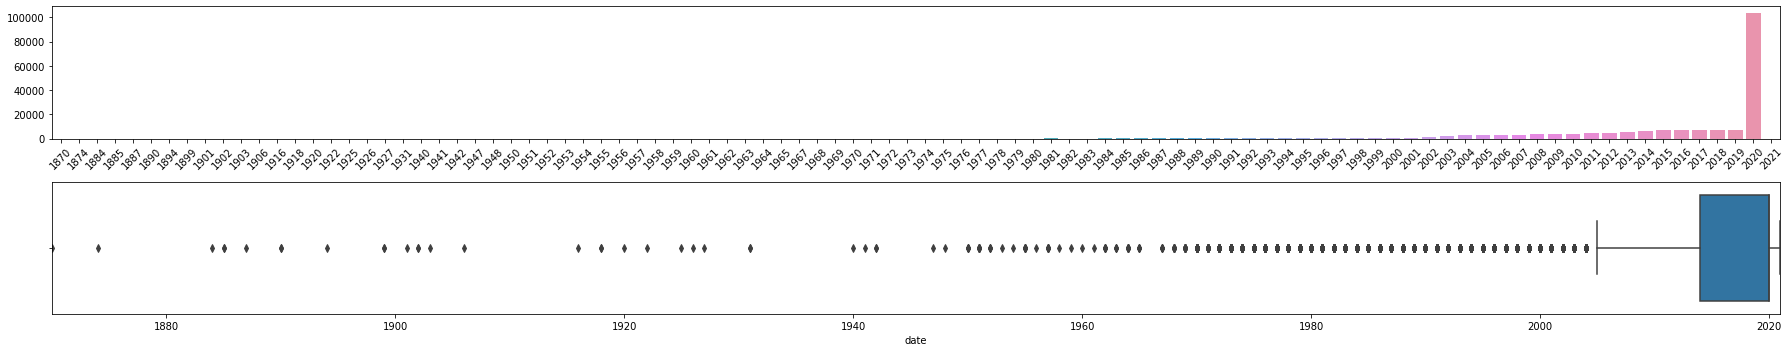

In [5]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [ ]:
emojis = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  e1 = demoji.findall(row["title"])
  if e1:
    for e in list(e1.keys()):
      emojis.add(e)
    # print(index, e1)

  e2 = demoji.findall(row["abstract"])
  if e2:
    for e in list(e2.keys()):
      emojis.add(e)
    # print(index, e2)

In [11]:
emojis

{'©', '®', '™', '▪️', '♦️', '⬇️'}

In [8]:
docs["abstract"][70663]

'Coronavirus EndoU inhibits dsRNA-activated antiviral responses; however, the physiologic RNA substrates of EndoU are unknown. In this study, we used mouse hepatitis virus (MHV)-infected bone-marrow-derived macrophage (BMM) and cyclic phosphate cDNA sequencing to identify the RNA targets of EndoU. EndoU targeted viral RNA, cleaving the 3′ side of pyrimidines with a strong preference for U⬇A and C⬇A sequences (endoY⬇A). EndoU-dependent cleavage was detected in every region of MHV RNA, from the 5′ NTR to the 3′ NTR, including transcriptional regulatory sequences (TRS). Cleavage at two CA dinucleotides immediately adjacent to the MHV poly(A) tail suggest a mechanism to suppress negative-strand RNA synthesis and the accumulation of viral dsRNA. MHV with EndoU (EndoUmut) or 2′-5′ phosphodiesterase (PDEmut) mutations provoked the activation of RNase L in BMM, with corresponding cleavage of RNAs by RNase L. The physiologic targets of EndoU are viral RNA templates required for negative-strand 

In [14]:
keywords = ["covid 19", "covid-19", "covid19", "sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  text = " ".join([row["title"], row["abstract"]])
  if any(re.findall(r'|'.join(keywords), text, re.IGNORECASE)):
    keep.add(index)

  # the few documents without date contain at least one keyword
  if row["date"] and row["date"] is not pd.NaT:
    if row["date"].year >= 2019:         
        if any(re.findall(r'coronavirus', " ".join([row["title"], row["abstract"]]), re.IGNORECASE)):
          keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


In [18]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www.\.\S+', '', text)

def remove_doi(text):
    regex = r"\b(doi:\s+)?(10[.][0-9]{4,}(?:[.][0-9]+)*(?:(?![\"&\'<>])\S)+)\b"
    return re.sub(regex, "", text)

# decidere se tenere qualche carattere
def remove_punctuation(text):
    punctuation = string.punctuation + '“”'
    return "".join([i for i in text if i not in punctuation])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def replace_html_entities(text):
    return html.unescape(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

# TODO
def replace_emojis(text):
    pass
def remove_numbers(text):
    pass


# il lemmatizer di wordnet ha solo questi 4 tag 
def pos2wordnet(nltk_pos):
  if nltk_pos.startswith('J'):
    return wn.ADJ
  elif nltk_pos.startswith('V'):
    return wn.VERB
  elif nltk_pos.startswith('N'):
    return wn.NOUN
  elif nltk_pos.startswith('R'):
    return wn.ADV
  else:
    return wn.NOUN


def preprocess(text):
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    sent = sent.lower()
    sent = remove_urls(sent)
    sent = remove_doi(sent)
    sent = remove_extra_whitespace(sent)
    sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    sent = remove_punctuation(sent)
    sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      t = wnl.lemmatize(token, pos2wordnet(pos))
      result.append(t)
    
  return result

In [19]:
text = docs["title"][4582]
x = preprocess(text)
text, x

('Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China',
 ['therapeutic',
  'strategy',
  'outbreak',
  'scenario',
  'treat',
  'novel',
  'coronavirus',
  'originate',
  'wuhan',
  'china'])

## Word Cloud

In [20]:
titles = []
abstracts = []

for index, row in tqdm(docs.iterrows(), total=len(docs)):
  title_tokens = preprocess(row["title"])
  abstract_tokens = preprocess(row["abstract"])

  titles.extend(title_tokens)
  abstracts.extend(abstract_tokens)

  0%|          | 0/84048 [00:00<?, ?it/s]

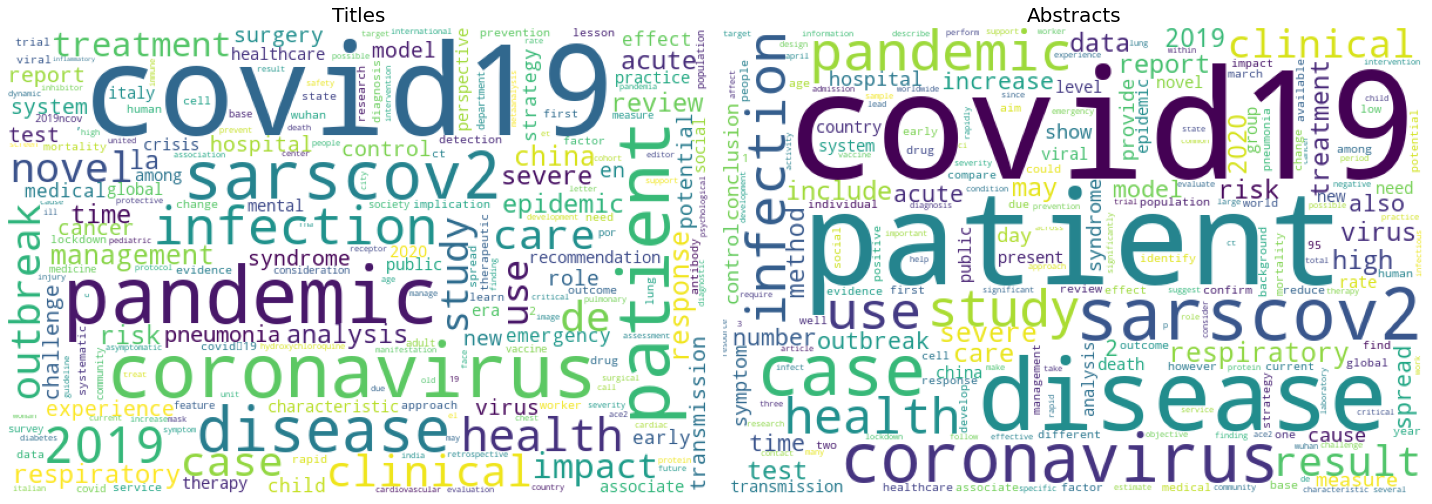

In [21]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [22]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, count in counter_title.most_common(k)]
top_k_abstracts = [word for word, count in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 29920
Abstracts: 116482

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


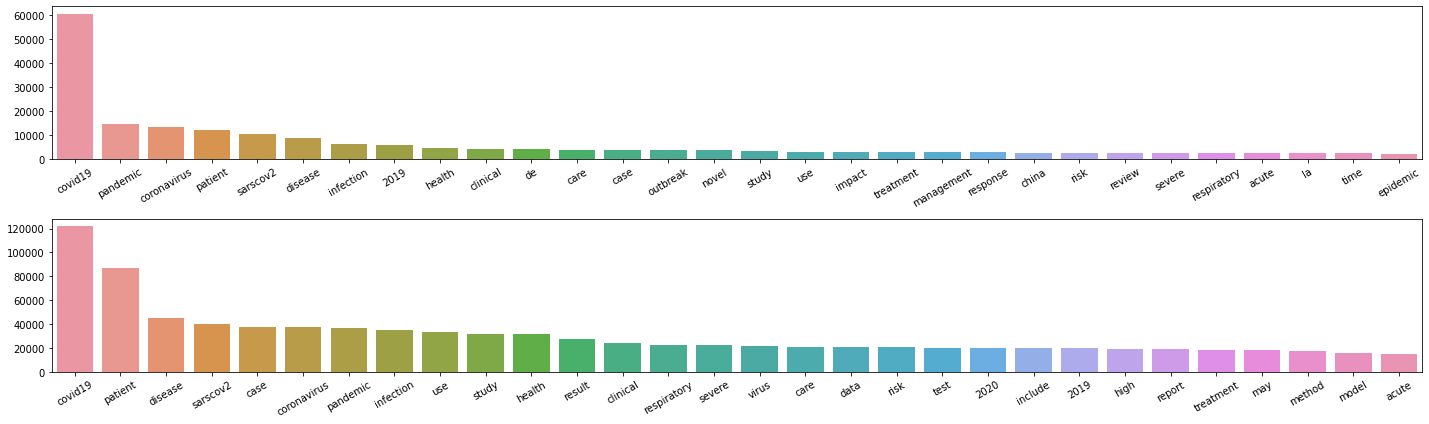

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 30)
fig.tight_layout()

## Entities

# Part 2: Basic Search

# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
